**Deep Clustering or Traditional Clustering techniques for BERT Embeddings**

Загрузка и предобработка данных

In [176]:
from sklearn.datasets import fetch_20newsgroups
random_state = 1337
categories = ['sci.crypt',
              'sci.electronics',
              'sci.med',
              'sci.space']
num_clusters = len(categories)
text = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=random_state).data
labels = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=random_state).target
len(text)

2373

In [177]:
import re
import nltk
nltk.download('stopwords')

def pre_process(str):
    str = str.lower()
    str = re.sub(r'[^\w\s]',' ',str) # Удаление знаков препинания
    tokens = nltk.word_tokenize(str)
    stop_words = nltk.corpus.stopwords.words('english')
    tokens = [w for w in tokens if not w in stop_words and len(w) > 2]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\St0negor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [178]:
processed_text = []
for doc in text:
    processed_text.append(pre_process(doc))
len(processed_text)

2373

Загрузим [предобученные модели BERT](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2) и получим вектора документов


In [179]:
%%time
from sentence_transformers import SentenceTransformer # Простой способ получить sentence embeddings из BERT

model = SentenceTransformer('all-MiniLM-L6-v2')
text_embedded = model.encode(processed_text)

Wall time: 5.99 s


In [180]:
text_embedded.shape

(2373, 384)

Для начала посмотрим на реальное расположение тематик

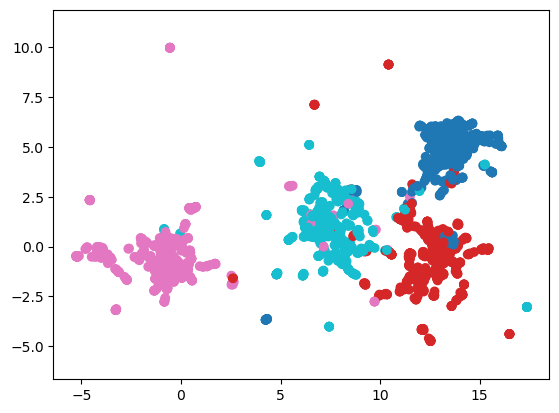

In [181]:
import matplotlib.pyplot as plt
import umap
reduced_data = umap.UMAP(n_components=2,metric='cosine',n_neighbors=5, min_dist=1e-4 ,random_state=random_state).fit_transform(text_embedded)
plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c = labels,
    cmap = 'tab10')
plt.gca().set_aspect('equal', 'datalim')
plt.show()

**Традиционные методы кластеризации**

In [182]:
def plot_prediction(reduced_data,prediction, labels, title):
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs = axs.ravel()
    axs[0].scatter(
        reduced_data[:, 0],
        reduced_data[:, 1],
        c = prediction,
        cmap = 'tab10')
    axs[0].title.set_text("Prediction")
    axs[1].scatter(
        reduced_data[:, 0],
        reduced_data[:, 1],
        c = labels,
        cmap = 'Set1')
    axs[1].title.set_text("Ground Truth")

    fig.suptitle(title, fontsize=16)
    plt.show()

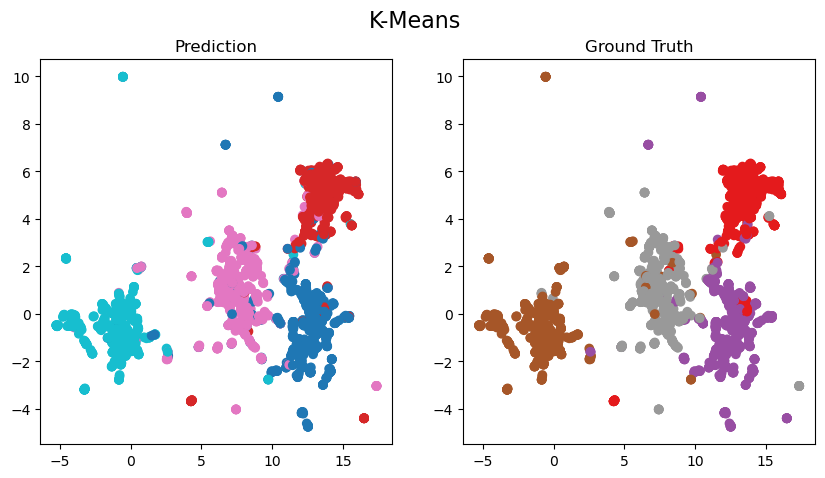

In [183]:
from sklearn.cluster import KMeans
prediction = KMeans(n_clusters=num_clusters, random_state=random_state).fit(text_embedded)

kmeans_prediction = prediction.labels_

plot_prediction(reduced_data,kmeans_prediction,labels, "K-Means")

[Определим](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc) значение eps для DBSCAN

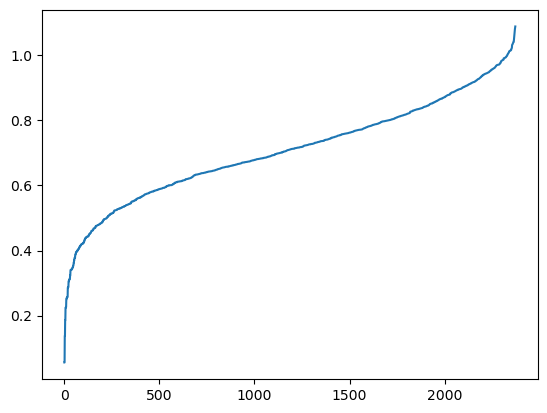

In [184]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(text_embedded)
distances, indices = nbrs.kneighbors(text_embedded)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

plt.show()

In [185]:
'''from sklearn.cluster import DBSCAN

for mins in [3,5,10,20,50,100]:
    prediction = DBSCAN(min_samples=mins, eps=1).fit(text_embedded)
    plot_prediction(prediction.labels_)'''

'from sklearn.cluster import DBSCAN\n\nfor mins in [3,5,10,20,50,100]:\n    prediction = DBSCAN(min_samples=mins, eps=1).fit(text_embedded)\n    plot_prediction(prediction.labels_)'

Для испробованных значений eps и min_samples DBSCAN не определяет более 2 класстеров в исходных данных.

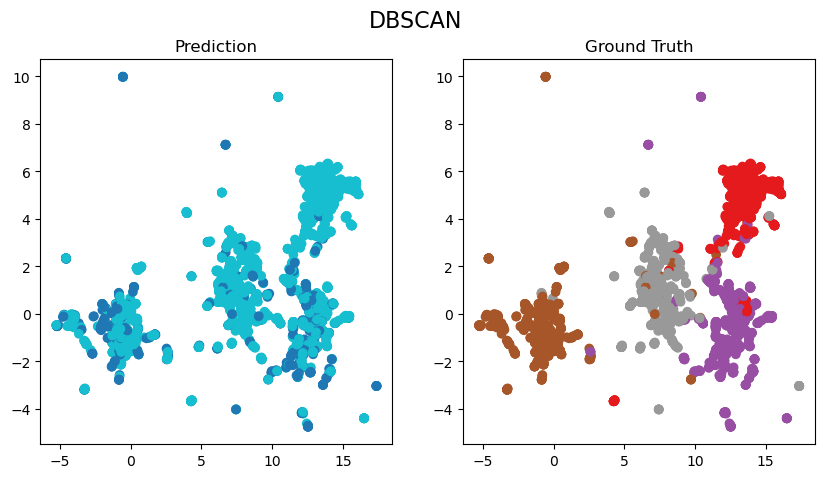

In [186]:
from sklearn.cluster import DBSCAN
prediction = DBSCAN(min_samples=50, eps=1).fit(text_embedded)

dbscan_prediction = prediction.labels_

plot_prediction(reduced_data,dbscan_prediction,labels,"DBSCAN")

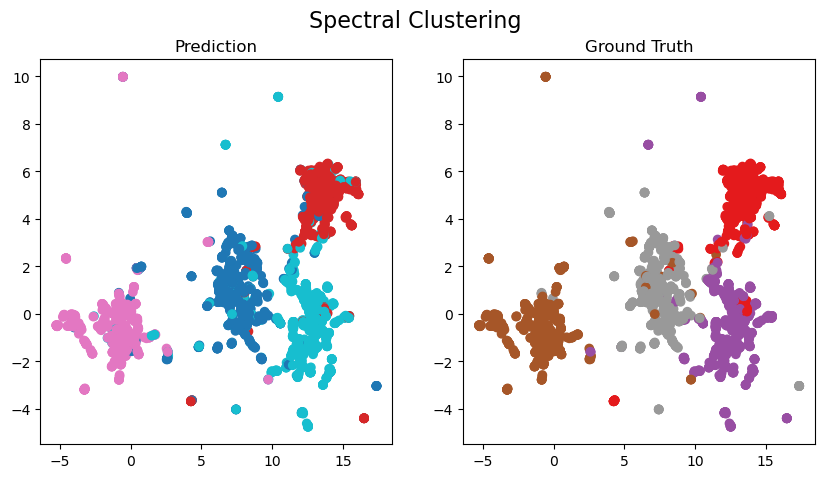

In [187]:
from sklearn.cluster import SpectralClustering
prediction = SpectralClustering(n_clusters=num_clusters, random_state=random_state).fit(text_embedded)

spectral_prediction = prediction.labels_

plot_prediction(reduced_data,spectral_prediction,labels,"Spectral Clustering")

**Deep Clustering**

Использую Deep Embedded Clustering [(PT-DEC)](https://github.com/vlukiyanov/pt-dec) модель.

In [188]:
import ptdec.dec as dec
from ptdec.model import train, predict
import torch
import torch.nn as nn
import torch.nn.functional as F

Сначала для PT-DEC необходимо определить энкодер

In [189]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(384, 256)
        self.linear2 = nn.Linear(256, latent_dims)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [190]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 384)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z

In [191]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [192]:
from tqdm.autonotebook import tqdm
def train_encoder(autoencoder, data, epochs=500):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data_loader:
            x = x.to(device)  # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat) ** 2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [193]:
%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dims = 128
autoencoder = Autoencoder(latent_dims).to(device)
data = torch.utils.data.TensorDataset(torch.tensor(text_embedded),torch.tensor(labels))
data_loader = torch.utils.data.DataLoader(data, batch_size=128)

autoencoder = train_encoder(autoencoder, data_loader, epochs=500).to(device)

encoder = autoencoder.encoder.to(device)

  0%|          | 0/500 [00:00<?, ?it/s]

Wall time: 33.3 s


Определим DEC модель и обучим её

In [194]:
dec_model = dec.DEC(cluster_number=num_clusters, hidden_dimension=latent_dims, encoder=encoder).to(device)

In [195]:
print(labels.shape, text_embedded.shape)
data = torch.utils.data.TensorDataset(torch.tensor(text_embedded),torch.tensor(labels))
optimizer = torch.optim.Adam(dec_model.parameters())
epochs = 5
batch_size = 200
train(data, dec_model, epochs, batch_size, optimizer)

(2373,) (2373, 384)


100%|██████████| 12/12 [00:00<00:00, 573.01batch/s, acc=0.0000, dlb=-1.0000, epo=-1, lss=0.00000000]
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 12/12 [00:00<00:00, 179.58batch/s, acc=0.9187, dlb=0.0135, epo=4, lss=0.15275894]


In [196]:
dec_prediction = np.array(predict(data, dec_model).cpu())

100%|██████████| 3/3 [00:00<00:00, 176.95batch/s]


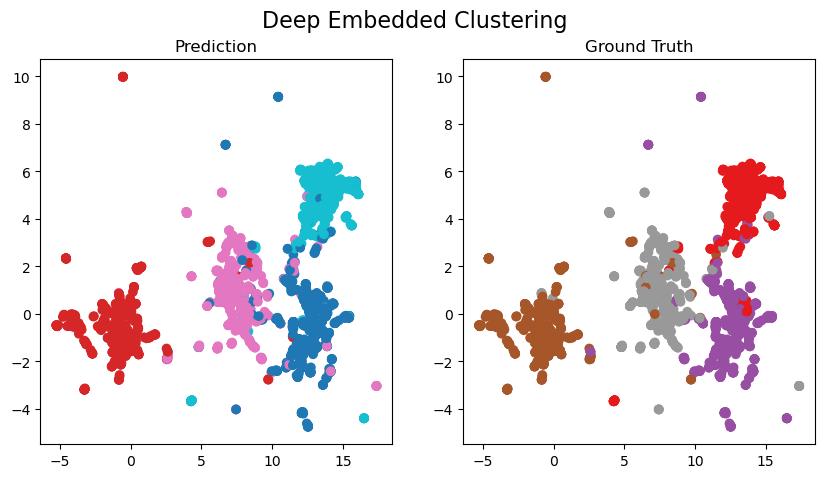

In [197]:
plot_prediction(reduced_data,dec_prediction,labels, "Deep Embedded Clustering")

Сравним метрики для всех использованных алгоритмов кластеризации

In [198]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import  davies_bouldin_score
from prettytable import PrettyTable
from sklearn.metrics import mutual_info_score
t = PrettyTable(['Clustering', 'DBI', 'Silhouette', 'Mutual Information'])

predictions = [kmeans_prediction, dbscan_prediction, spectral_prediction, dec_prediction]
algs = ["K-Means","DBSCAN","Spectral Clustering","Deep Embedded Clustering"]
t.align['Clustering'] = 'l'
for i, prediction in enumerate(predictions):

    dbi = davies_bouldin_score(text_embedded, prediction)

    ss = silhouette_score(text_embedded, prediction, metric='euclidean')

    mi = mutual_info_score(labels,prediction) # Внешняя метрика !!!

    t.add_row([algs[i], dbi, ss, mi])
print(t)

+--------------------------+--------------------+-------------+---------------------+
| Clustering               |        DBI         |  Silhouette |  Mutual Information |
+--------------------------+--------------------+-------------+---------------------+
| K-Means                  | 3.7565410879851715 | 0.060372964 |  1.0324247712706822 |
| DBSCAN                   | 6.562498929121846  | 0.045685824 | 0.07597206403425344 |
| Spectral Clustering      | 3.7788335593760563 | 0.058401063 |  0.9577709280394109 |
| Deep Embedded Clustering | 3.8305029680455136 |  0.05998232 |  1.0648254127985666 |
+--------------------------+--------------------+-------------+---------------------+


Deep Clustering показал результаты чуть лучше, чем K-Means.
Предполагаю, эта разница станет значительно заметнее на более сложных данных.

Попробуем [другой датасет](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

In [199]:
%%time
import pandas as pd
df = pd.read_csv('data/Clothing.csv')
df = df.dropna()
text = list(df.iloc[:, 4])

labels = list(df.iloc[:, 9])
dct = {'Dresses':0,
       'Bottoms':1,
       "Tops":2,
       "Intimate":3,
       "Jackets":4,
       "Trend":5}
labels = [dct[key] for key in labels]

num_clusters = 6
processed_text = []

for doc in text:
    processed_text.append(pre_process(doc))

text_embedded = model.encode(processed_text)

Wall time: 17.8 s


K-Means

In [200]:
from sklearn.cluster import KMeans
prediction = KMeans(n_clusters=num_clusters, random_state=random_state).fit(text_embedded)

kmeans_prediction = prediction.labels_

Deep Clustering

In [201]:
%%time
autoencoder = Autoencoder(latent_dims).to(device)
data = torch.utils.data.TensorDataset(torch.tensor(text_embedded), torch.tensor(labels))

data_loader = torch.utils.data.DataLoader(data, batch_size=128)

autoencoder = train_encoder(autoencoder, data_loader, epochs=500).to(device)
encoder = autoencoder.encoder.to(device)

dec_model = dec.DEC(cluster_number=num_clusters, hidden_dimension=latent_dims, encoder=encoder).to(device)

  0%|          | 0/500 [00:00<?, ?it/s]

Wall time: 4min 18s


In [202]:
data = torch.utils.data.TensorDataset(torch.tensor(text_embedded), torch.tensor(labels))
optimizer = torch.optim.Adam(dec_model.parameters())
epochs = 10
batch_size = 200

train(data, dec_model, epochs, batch_size, optimizer)
dec_prediction = np.array(predict(data, dec_model).cpu())

100%|██████████| 99/99 [00:00<00:00, 533.68batch/s, acc=0.0000, dlb=-1.0000, epo=-1, lss=0.00000000]
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 20/20 [00:00<00:00, 124.58batch/s]


Сравним метрики для более сложного dataset-а.

In [203]:
t = PrettyTable(['Clustering', 'DBI', 'Silhouette', 'Mutual Information'])

predictions = [kmeans_prediction, dec_prediction]
algs = ["K-Means","Deep Embedded Clustering"]
t.align['Clustering'] = 'l'
for i, prediction in enumerate(predictions):

    dbi = davies_bouldin_score(text_embedded, prediction)

    ss = silhouette_score(text_embedded, prediction, metric='euclidean')

    mi = mutual_info_score(labels,prediction) # Внешняя метрика !!!

    t.add_row([algs[i], dbi, ss, mi])
print(t)

+--------------------------+-------------------+-------------+---------------------+
| Clustering               |        DBI        |  Silhouette |  Mutual Information |
+--------------------------+-------------------+-------------+---------------------+
| K-Means                  | 4.663004086992736 |  0.01752843 |  0.3528335230074153 |
| Deep Embedded Clustering | 5.438968060320851 | 0.025045825 | 0.43553074559864485 |
+--------------------------+-------------------+-------------+---------------------+


Разница в показателях действительно увеличилась, но не так значительно, как я ожидал

**Выводы**
1) Разность в эффективности традиционных алгоритмов кластеризации и Deep Clustering растёт с ростом сложности данных.
2) K-Means стоит пробовать первым даже на сложных данных, так как может показать хорошие результаты.
